In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator
import json
import ptitprince as pt
import pickle as pkl
# import contextily as ctx
from src.data.analyse import *
from ema_workbench import load_results
sns.set_theme(style="ticks")

## Load results

In [66]:
# Load results
results = load_results('../results/scenarios=1000, policies=20.tar.gz')

# Prepare outcomes data frame
outcomes = prepare_outcomes(results, add_policies=True)

# This outcome should be studied separately
outcomes.drop('years_in_poverty', axis=1, inplace=True)

# Convert columns of interest to numeric (we read them as objects)
numeric_columns = outcomes.columns[4:].tolist()
outcomes[numeric_columns] = outcomes[numeric_columns].apply(pd.to_numeric)

## EDA

In [67]:
# Split my policy into two columns
outcomes[['target_group', 'top_up']] = outcomes['my_policy'].str.split('+', expand=True)
# Make top_up a categorical variable to ensure it is ordered correctly
outcomes['top_up'] = pd.Categorical(outcomes['top_up'], categories=['0', '10', '30', '50', '100'])

# Convert some outcomes to percentages
outcomes['annual_average_consumption_loss_pct'] = outcomes['annual_average_consumption_loss_pct'] * 100
outcomes['initial_poverty_gap'] = outcomes['initial_poverty_gap'] * 100
outcomes['new_poverty_gap'] = outcomes['new_poverty_gap'] * 100

# Define a new outcome: n_new_poor_increase_pct
outcomes = outcomes.assign(n_new_poor_increase_pct = outcomes['n_new_poor'].div(outcomes['total_population']).multiply(100))

In [123]:
df = outcomes.copy()
columns_of_interest = [
       'target_group',
       'top_up', 
       'n_new_poor',
       'annual_average_consumption_loss_pct']
tab = df[columns_of_interest].round(2).groupby(['target_group', 'top_up']).mean(numeric_only=True).round(2)

In [124]:
top_up_mapper = {'0' : 'None', '10' : '10%', '30': '30%', '50': '50%', '100': '100%'}
target_group_mapper = {'all' : 'All', 'poor' : 'Poor', 'poor_near_poor1.25' : 'Poor and Near Poor (1.25)', 'poor_near_poor2.0' : 'Poor and Near Poor (2.0)'}
outcome_name_mapper = {'annual_average_consumption_loss_pct' : 'Annual average consumption loss (%)', 'n_new_poor' : 'Number of new poor'}

tab.rename(index = top_up_mapper, inplace = True)
tab.rename(index = target_group_mapper, inplace = True)
tab.rename(columns = outcome_name_mapper, inplace = True)
tab.index.names = ['Target group', 'Top-up percentage']

tab['Number of new poor'] = tab['Number of new poor'].astype(int)

In [125]:
tab

Number of new poor  \
Target group              Top-up percentage                       
All                       None                              166   
                          10%                               160   
                          30%                               148   
                          50%                               137   
                          100%                              106   
Poor                      None                              166   
                          10%                               166   
                          30%                               166   
                          50%                               166   
                          100%                              166   
Poor and Near Poor (1.25) None                              166   
                          10%                               164   
                          30%                               162   
                          50%                               160   
                          100%                              150   
Poor and Near Poor (2.0)  None                              166   
                          10%                               162   
                          30%                               152   
                          50%                               143   
                          100%                              117   

                                             Annual average consumption loss (%)  
Target group              Top-up percentage                                       
All                       None                                             26.21  
                          10%                                              25.32  
                          30%                                              23.61  
                          50%                                              21.91  
                          100%                                             17.26  
Poor                      None                                             26.21  
                          10%                                              26.12  
                          30%                                              25.96  
                          50%                                              25.81  
                          100%                                             25.42  
Poor and Near Poor (1.25) None                                             26.21  
                          10%                                              26.05  
                          30%                                              25.77  
                          50%                                              25.51  
                          100%                                             24.77  
Poor and Near Poor (2.0)  None                                             26.21  
                          10%                                              25.85  
                          30%                                              25.19  
                          50%                                              24.54  
                          100%                                             22.77

In [126]:
n_target_groups = 4
k = 0
m_top_ups = 4
for i in range(n_target_groups):
    x = tab.iloc[k, 0]
    y = tab.iloc[k, 1]
    tab.iloc[k, 0] = 0
    tab.iloc[k, 1] = 0
    for j in range(k + 1, k + m_top_ups + 1):
        tab.iloc[j, 0] = x - tab.iloc[j, 0]
        tab.iloc[j, 1] = y - tab.iloc[j, 1]
    k += m_top_ups + 1

tab.columns = ['Average number of people preventing from falling into poverty',
               'Average reduction in consumption loss (%)']
tab = tab + 0

In [127]:
tab

Average number of people preventing from falling into poverty  \
Target group              Top-up percentage                                                                  
All                       None                                                               0               
                          10%                                                                6               
                          30%                                                               18               
                          50%                                                               29               
                          100%                                                              60               
Poor                      None                                                               0               
                          10%                                                                0               
                          30%                                                                0               
                          50%                                                                0               
                          100%                                                               0               
Poor and Near Poor (1.25) None                                                               0               
                          10%                                                                2               
                          30%                                                                4               
                          50%                                                                6               
                          100%                                                              16               
Poor and Near Poor (2.0)  None                                                               0               
                          10%                                                                4               
                          30%                                                               14               
                          50%                                                               23               
                          100%                                                              49               

                                             Average reduction in consumption loss (%)  
Target group              Top-up percentage                                             
All                       None                                                    0.00  
                          10%                                                     0.89  
                          30%                                                     2.60  
                          50%                                                     4.30  
                          100%                                                    8.95  
Poor                      None                                                    0.00  
                          10%                                                     0.09  
                          30%                                                     0.25  
                          50%                                                     0.40  
                          100%                                                    0.79  
Poor and Near Poor (1.25) None                                                    0.00  
                          10%                                                     0.16  
                          30%                                                     0.44  
                          50%                                                     0.70  
                          100%                                                    1.44  
Poor and Near Poor (2.0)  None                                                    0.00  
                      

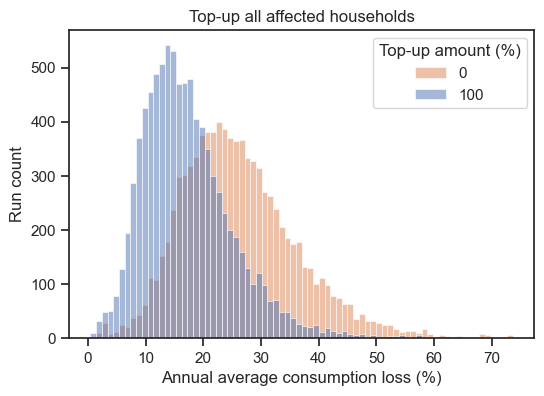

In [93]:
fig, ax = plt.subplots(figsize=(6, 4))

target_group = 'all'
top_ups = ['0', '100']
df = outcomes[outcomes['target_group'] == target_group].copy()
df['top_up'] = df['top_up'].astype(str)
df = df[df['top_up'].isin(top_ups)]
outcome_of_interest = 'annual_average_consumption_loss_pct'
sns.histplot(data=df, x=outcome_of_interest, hue='top_up', ax=ax)
plt.xlabel('Annual average consumption loss (%)')
plt.ylabel('Run count')
plt.legend(title='Top-up amount (%)', labels=['0', '100'])
plt.title('Top-up all affected households');

In [97]:
df.groupby('top_up').describe()[[outcome_of_interest]]

annual_average_consumption_loss_pct                                  \
                                     count       mean        std       min   
top_up                                                                       
0                                   9000.0  26.207434  10.114633  1.238086   
100                                 9000.0  17.261311   7.935331  0.437174   

                                                    
              25%        50%        75%        max  
top_up                                              
0       19.150819  25.032922  31.899313  73.689437  
100     11.714449  16.013415  21.356574  61.915909

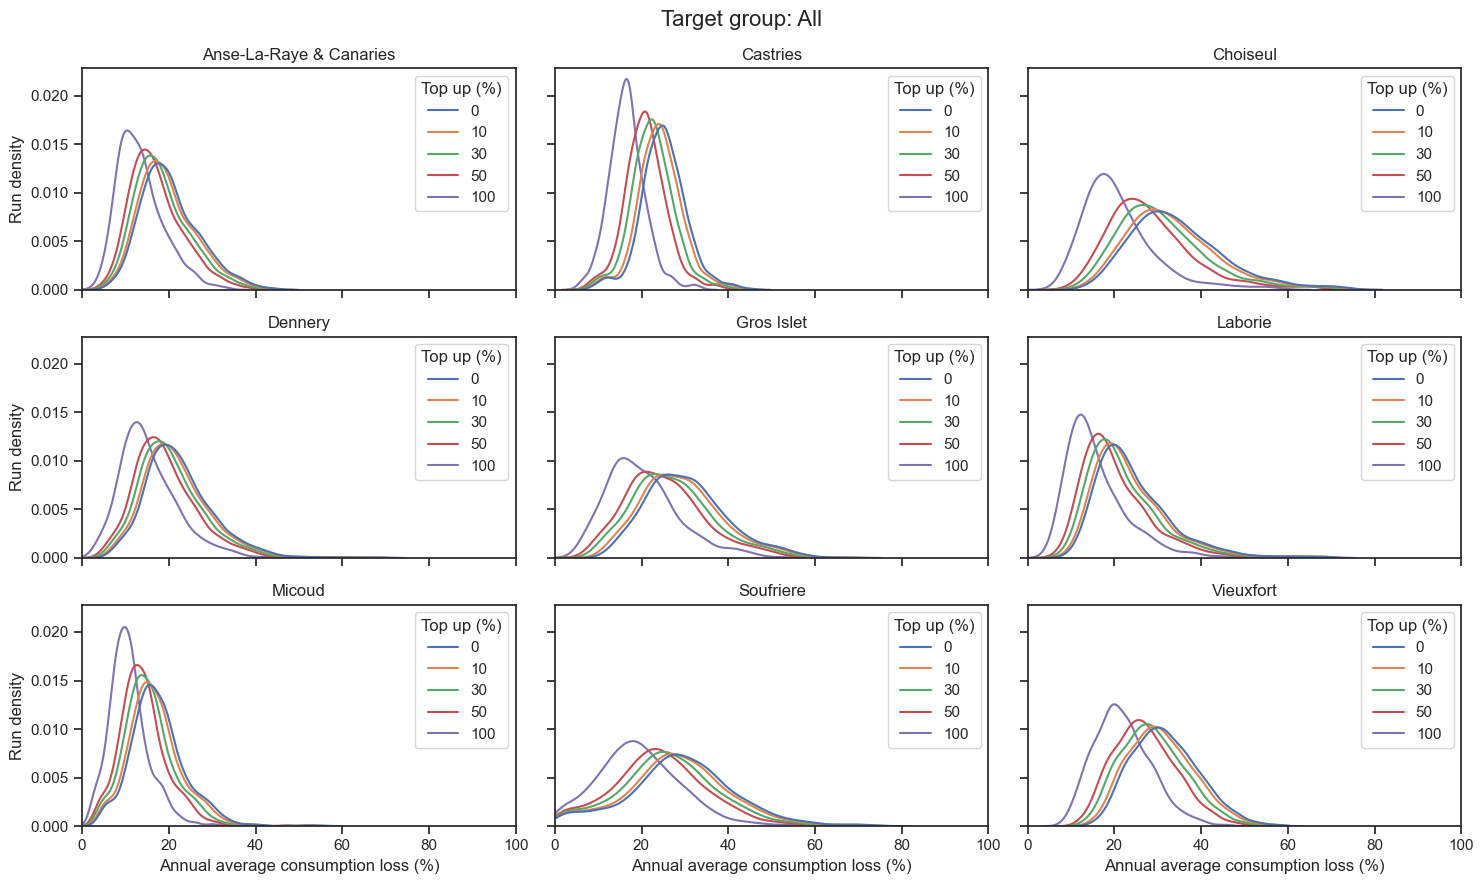

In [30]:
target_group = 'all'
df = outcomes[outcomes['target_group'] == target_group]

districts = df['district'].unique().tolist()
n_districts = len(districts)

fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 3 * n_districts / 3), sharex=True, sharey=True)
colors = sns.color_palette('Set2', n_colors=len(districts))

# outcome_of_interest = 'n_new_poor'

outcome_name_mapper = {'annual_average_consumption_loss_pct': 'Annual average consumption loss (%)',
                           'n_new_poor': 'Number of new poor',
                           'n_new_poor_increase_pct' : 'Increase in number of new poor (%)'}

for district in districts:
    data = df[df['district'] == district][['top_up', outcome_of_interest]]
    data.sort_values('top_up', inplace=True)
    data.rename(columns={'top_up': 'Top up (%)'}, inplace=True)
    if district == 'AnseLaRayeCanaries':
        district_name = 'Anse-La-Raye & Canaries'
    else:
        district_name = district
    i = districts.index(district) // 3
    j = districts.index(district) % 3
    color = colors[districts.index(district)]
    # sns.histplot(data=data, 
    #              x=outcome_of_interest, 
    #              hue='Top up', 
    #              ax=ax[i, j], 
    #              # multiple='stack', 
    #              # shrink=.8,
    #              # palette="ch:rot=-.25,hue=1,light=.75"
    #              )
    sns.kdeplot(data=data, 
                 x=outcome_of_interest, 
                 hue='Top up (%)', 
                 ax=ax[i, j], 
                 )
    ax[i, j].set_title(district_name)
    ax[i, j].set_ylabel('Run density')
    ax[i, j].set_xlabel(outcome_name_mapper[outcome_of_interest])
    ax[i, j].set_xlim(0, 100)
fig.suptitle('Target group: ' + target_group_names[target_group], fontsize=16)
fig.tight_layout()